In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Kaggle')

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #download dataset from kaggle

 97% 656M/675M [00:05<00:00, 154MB/s]
100% 675M/675M [00:05<00:00, 119MB/s]


In [ ]:
import os
# Complete path to storage location of the .zip file of data
zip_path = '/content/drive/MyDrive/Kaggle/cell-images-for-detecting-malaria.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'cell-images-for-detecting-malaria.zip'
# View the unzipped contents in the virtual machine
os.listdir()

cp: '/content/drive/MyDrive/Kaggle/cell-images-for-detecting-malaria.zip' and './cell-images-for-detecting-malaria.zip' are the same file


['kaggle.json', 'cell-images-for-detecting-malaria.zip', 'cell_images']

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install numpy tensorflow opencv-python sklearn matplotlib


     |████████████████████████████████| 462 kB 28.2 MB/s 


In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# after you extract the dataset,
# put cell_images folder in the working directory
img_dir="/content/drive/MyDrive/Kaggle/cell_images"
img_size=70

def load_img_data(path):
    image_files = glob.glob(os.path.join(path, "Parasitized/*.png")) + \
                  glob.glob(os.path.join(path, "Uninfected/*.png"))
    X, y = [], []
    for image_file in image_files:
        # 0 for uninfected and 1 for infected
        label = 0 if "Uninfected" in image_file else 1
        # load the image in gray scale
        img_arr = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        # resize the image to (70x70)
        img_resized = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_resized)
        y.append(label)
    return X, y

In [ ]:
# load the data
X, y = load_img_data(img_dir)
# reshape to (n_samples, 70, 70, 1) (to fit the NN)
X = np.array(X).reshape(-1, img_size, img_size, 1)
# scale pixels from the range [0, 255] to [0, 1]
# to help the neural network learn much faster
X = X / 255

# shuffle & split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
print("Total training samples:", X_train.shape)
print("Total validation samples:", X_test.shape[0])

Total training samples: (24802, 70, 70, 1)
Total validation samples: 2756


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# train the model with 3 epochs, 64 batch size
model.fit(X_train, np.array(y_train), batch_size=64, epochs=3, validation_split=0.2)
# if you already trained the model, uncomment below and comment above
# so you can only load the previously trained model
# model.load_weights("malaria-cell-cnn.h5")

Epoch 1/3
311/311 [==============================] - 19s 20ms/step - loss: 0.4948 - accuracy: 0.7233 - val_loss: 0.2061 - val_accuracy: 0.9184
Epoch 2/3
311/311 [==============================] - 6s 18ms/step - loss: 0.1667 - accuracy: 0.9395 - val_loss: 0.1641 - val_accuracy: 0.9373
Epoch 3/3
311/311 [==============================] - 6s 18ms/step - loss: 0.1454 - accuracy: 0.9470 - val_loss: 0.1514 - val_accuracy: 0.9424


In [ ]:
loss, accuracy = model.evaluate(X_test, np.array(y_test), verbose=0)
print(f"Testing on {len(X_test)} images, the results are\n Accuracy: {accuracy} | Loss: {loss}")

Testing on 2756 images, the results are
 Accuracy: 0.9466618299484253 | Loss: 0.14011675119400024


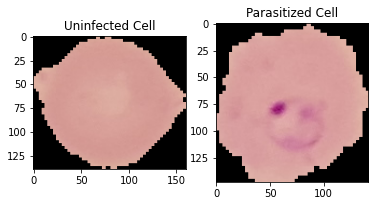

In [ ]:
# testing some images
uninfected_cell = "/content/drive/MyDrive/Kaggle/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png"
infected_cell = "/content/drive/MyDrive/Kaggle/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"

_, ax = plt.subplots(1, 2)
ax[0].imshow(plt.imread(uninfected_cell))
ax[0].title.set_text("Uninfected Cell")
ax[1].imshow(plt.imread(infected_cell))
ax[1].title.set_text("Parasitized Cell")
plt.show()

In [ ]:
img_arr_uninfected = cv2.imread(uninfected_cell, cv2.IMREAD_GRAYSCALE)
img_arr_infected = cv2.imread(infected_cell, cv2.IMREAD_GRAYSCALE)
# resize the images to (70x70)
img_arr_uninfected = cv2.resize(img_arr_uninfected, (img_size, img_size))
img_arr_infected = cv2.resize(img_arr_infected, (img_size, img_size))
# scale to [0, 1]
img_arr_infected = img_arr_infected / 255
img_arr_uninfected = img_arr_uninfected / 255
# reshape to fit the neural network dimensions
# (changing shape from (70, 70) to (1, 70, 70, 1))
img_arr_infected = img_arr_infected.reshape(1, *img_arr_infected.shape)
img_arr_infected = np.expand_dims(img_arr_infected, axis=3)
img_arr_uninfected = img_arr_uninfected.reshape(1, *img_arr_uninfected.shape)
img_arr_uninfected = np.expand_dims(img_arr_uninfected, axis=3)

In [ ]:
# perform inference
infected_result = model.predict(img_arr_infected)[0][0]
uninfected_result = model.predict(img_arr_uninfected)[0][0]
print(f"Infected: {infected_result}")
print(f"Uninfected: {uninfected_result}")

Infected: 0.9988405108451843
Uninfected: 0.010209734551608562


In [ ]:
# save the model & weights
model.save("malaria-cell-cnn.h5")